# Ziegler-Nichols PID Tuning

The goal of this notebook is to go over a specific version of PID tuning, the Ziegler-Nichols method. The overarching goal can be viewed on the appropriate Wikipedia page (https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method); however, a brief description is as follows.  Start by setting the I and D components of the PID to zero and have the proportional component set to an low, but appropriate value.  Given an appropriate setpoint, slowly increase the value of the proportional gain ($K_p$) until the system process begins to ocsilate.  This proportional gain is known as the ultimate gain ($K_u$) and the corresponding oscillation period is denoted $T_u$.  Given these two values, you can follow the table on the Wikipedia page to determine what you should set your PID parameters to.

The goal of this notebook is to create an object oriented approach to setting up the Ziegler-Nichols PID tuning paradigm, given a fake system that can be simulated.

In [1]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt

The first step is to set up an object that represents the PID controller. This object will be in charge of storing the appropriate PID values and have the method for proprosing the control output based on the setpoint and current value.

In [2]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint):
        """
        Initialize the PID controller.
        
        Args:
            Kp (float): Proportional gain
            Ki (float): Integral gain
            Kd (float): Derivative gain
            setpoint (float): Desired value of the controlled variable
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0  # Accumulated integral error
        self.previous_error = 0  # Error from the previous update
    
    def update(self, measured_value, dt):
        """
        Update the PID controller and calculate the control output.
        
        Args:
            measured_value (float): Current value of the controlled variable
            dt (float): Time step since the last update
        
        Returns:
            float: The control output
        """
        # Calculate error (difference between setpoint and measured value)
        error = self.setpoint - measured_value
        
        # Proportional term: proportional to the current error
        P = self.Kp * error
        
        # Integral term: sum of all past errors
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term: rate of change of error
        derivative = (error - self.previous_error) / dt
        D = self.Kd * derivative
        
        # Compute the control output by summing P, I, and D terms
        output = P + I + D
        
        # Store the current error for the next iteration
        self.previous_error = error
        
        return output

For this notebooks purpose, we are going to create a very simple system that can be used to see how this method would effectively run.  Below is the code block for that system.

In [3]:
def simulate_process(control_signal, previous_value):
    """
    Simulate a simple second-order dynamic system.

    This function models a basic process that responds to a control signal.
    It represents a simplified version of a real-world system, where the
    current state depends on both the input (control signal) and the
    previous state.

    Args:
        control_signal (float): The input signal to the system, typically
                                from a controller like PID.
        previous_value (float): The output value of the system in its
                                previous state.

    Returns:
        float: The new output value of the simulated system.

    Notes:
        - The equation used is a simplified model: 
          new_value = previous_value + (control_signal * 0.1) - (0.05 * previous_value)
        - The coefficient 0.1 represents the system's responsiveness to the control signal.
        - The term -0.05 * previous_value introduces a damping effect, preventing 
          unbounded growth and adding some "inertia" to the system.
        - This is a very basic simulation and may not accurately represent 
          complex real-world systems.
    """
    return previous_value + control_signal * 0.1 - 0.05 * previous_value

Lastly, we need to write the code for the actual Ziegler-Nichols Tuning.  This is represented as follows.

In [4]:
def ziegler_nichols_tuning(setpoint=1, initial_Kp=1, max_iterations=100, dt=0.1):
    """
    Perform Ziegler-Nichols tuning for a PID controller.

    This function implements the Ziegler-Nichols tuning method, which is used to
    find optimal PID controller parameters. It gradually increases the proportional
    gain until the system begins to oscillate, then uses the critical gain and
    oscillation period to calculate the PID parameters.

    Args:
        setpoint (float): The desired value for the controlled variable. Default is 1.
        initial_Kp (float): The initial value for the proportional gain. Default is 1.
        max_iterations (int): The maximum number of iterations to run the simulation. Default is 100.
        dt (float): The time step for each iteration. Default is 0.1.

    Returns:
        tuple: A tuple containing:
            - Kp_final (float): The final proportional gain, or None if tuning failed.
            - Ki_final (float): The final integral gain, or None if tuning failed.
            - Kd_final (float): The final derivative gain, or None if tuning failed.
            - measured_values (list): A list of process values recorded during tuning.
            - time_values (list): A list of time values corresponding to the measured values.

    Notes:
        - The function uses a simulated process (simulate_process) and a PID controller (PIDController).
        - It increases Kp until sustained oscillations are detected.
        - The critical gain (K_crit) is the Kp value that causes sustained oscillations.
        - The critical period (T_crit) is the time between oscillations.
        - PID parameters are calculated using Ziegler-Nichols formulas (classic PID):
          Kp = 0.6 * K_crit
          Ki = 2 * Kp / T_crit
          Kd = Kp * T_crit / 8
    """
    process_value = 0
    Kp = initial_Kp
    Ki = 0
    Kd = 0
    pid = PIDController(Kp, Ki, Kd, setpoint)
    measured_values = []
    time_values = []
    oscillation_started = False
    K_crit = None
    T_crit = None
    prev_sign = None
    cross_time = None
    osc_count = 0
    
    for i in range(max_iterations):
        # Get control signal from PID controller
        control_signal = pid.update(process_value, dt)
        
        # Simulate the process response
        process_value = simulate_process(control_signal, process_value)
        
        # Record the process value and time
        measured_values.append(process_value)
        time_values.append(i * dt)
        
        # Check if the process starts oscillating
        if i > 1 and not oscillation_started:
            if measured_values[-1] * measured_values[-2] < 0:  # Zero crossing (sign change)
                oscillation_started = True
                prev_sign = np.sign(measured_values[-1])
                cross_time = i * dt
                osc_count = 1

        # After oscillation starts, detect further zero crossings to calculate the oscillation period
        if oscillation_started and measured_values[-1] * prev_sign < 0:
            prev_sign = np.sign(measured_values[-1])
            osc_count += 1
            if osc_count == 3:  # Wait for two full oscillations
                T_crit = (i * dt) - cross_time  # Calculate the oscillation period
                K_crit = Kp
                break
        
        # Increase Kp until oscillations start
        Kp += 0.1
        pid.Kp = Kp

    # Calculate PID gains using Ziegler-Nichols method (for a PID controller)
    if K_crit and T_crit:
        Kp_final = 0.6 * K_crit
        Ki_final = 2 * Kp_final / T_crit
        Kd_final = Kp_final * T_crit / 8
        print(f"Ziegler-Nichols tuning results: Kp={Kp_final}, Ki={Ki_final}, Kd={Kd_final}")
        return Kp_final, Ki_final, Kd_final, measured_values, time_values
    else:
        print("Oscillations did not start.")
        return None, None, None, measured_values, time_values

Ziegler-Nichols tuning results: Kp=17.70000000000009, Ki=177.00000000000153, Kd=0.4425000000000007


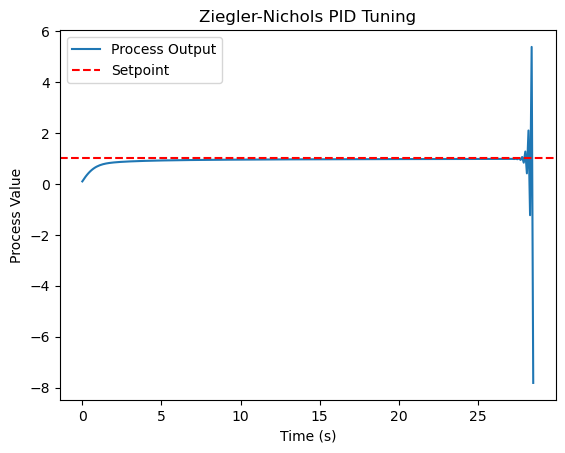

In [5]:
# Run the Ziegler-Nichols tuning method
Kp, Ki, Kd, measured_values, time_values = ziegler_nichols_tuning(max_iterations=1000)

# Plot the process response
plt.plot(time_values, measured_values, label="Process Output")
plt.axhline(y=1, color='r', linestyle='--', label="Setpoint")
plt.xlabel('Time (s)')
plt.ylabel('Process Value')
plt.title('Ziegler-Nichols PID Tuning')
plt.legend()
plt.show()